In [2]:
import numpy as np
import scipy
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit_aer import AerSimulator
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
from scipy.optimize import minimize
import warnings
import sys
import functools
import scipy as sc
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings('ignore')

In [2]:
initial_state = Statevector.from_label('00000')
step = 10
time = 1
time_step = 20
nqubits = 4
periodic = True
J = 1/np.sqrt(2)
def get_hamiltonian_y(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZY', [nqubits, 1, 0], J)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()


def get_hamiltonian_i(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZI', [nqubits, 1, 0], J)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()

def get_hamiltonian(nqubits, J):
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()



##  without vqe

In [3]:
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 40
## 1st order
def construct_trotter_circuit(H, time, nqubits, order, time_step):
    if order == 1:
        formular = LieTrotter(reps=time_step)
    else:
        formular = SuzukiTrotter(order=order, reps=time_step)
    trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
    circuit = QuantumCircuit(nqubits+1)
    circuit.append(trotter_step_first_order, range(nqubits+1))
    #circuit = circuit.decompose(reps=2)
    return circuit

def select_sim(error_rate):
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    if error_rate==0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
    return simulator

def unitary_trotter(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_list = []
    probability_list = []
    statevector = initial_state.data
    for i in range(step):
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        #qc = qc.decompose(reps=2)
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data#
        new_state_0= new_state[:2**nqubits]
        # Print the statevector at each step for debugging
        #print(f"Step {i}: Statevector = {statevector}")
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        if i ==0:
            probability = new_state_0.conj().T.dot(new_state_0)
        else:
            probability = new_state_0.conj().T.dot(new_state_0)
            probability *= probability_list[-1]
        expectation_list.append(expectation)
        probability_list.append(probability)
        # Print the expectation value at each step for debugging
        #print(f"Step {i}: Expectation = {expectation}")
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_list, probability_list

In [4]:
order = 1
result = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
expectation_1 = result[0]
probability_1 = result[1]

In [5]:
order = 2
result = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
expectation_2 = result[0]
probability_2 = result[1]

In [6]:
def unitary_exact(time, nqubits, error_rate, step):
    projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
    J = 1/np.sqrt(2)
    hamiltonian = get_hamiltonian(nqubits, J)
    H_array = hamiltonian.to_matrix()
    eval, _ = np.linalg.eigh(H_array)
# print(eval)
    emin = eval[0]
    emax = eval[-1]
    H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
    initial_state = Statevector.from_label("0"*nqubits)
    expectation_exact = []
    probability_exact = []
    simulator = select_sim(error_rate)
    statevector = initial_state.data
    for i in range(step):
        U = expm(-1.0j * time * np.kron(projector, H_array))
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        qc.unitary(U, range(nqubits+1))
        qc.decompose(reps=2)
        qc.save_statevector()
        result = simulator.run(qc).result().data(0)['statevector']
        new_state = result.data#
        new_state_0 = new_state[:2**nqubits]
        expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_exact.append(expectation)
        if i ==0:
            probability = new_state_0.conj().T.dot(new_state_0)
        else:
            probability = new_state_0.conj().T.dot(new_state_0)
            probability *= probability_exact[-1]
        probability_exact.append(probability)
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_exact, probability_exact

result = (unitary_exact(np.pi/2, 4, 0, 40))
expectation_exact = result[0]
probability_exact = result[1]

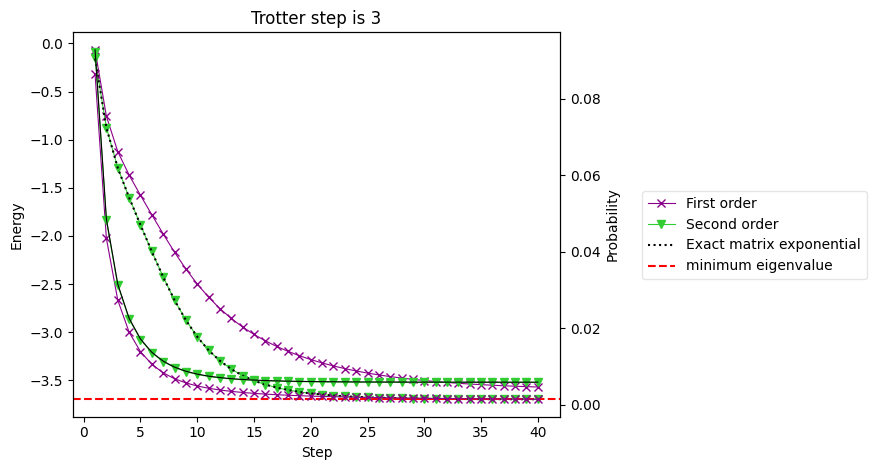

In [7]:
fig, axes = plt.subplots()
x = list(range(1, step+1))  # includes initial state
axes.plot(
    x, expectation_1, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    x, expectation_2, label="Second order", marker="v", c="limegreen", ls="-", lw=0.8
)
#axes.plot(
#    x, expectation_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
#)
axes.plot(x, expectation_exact, c="k", ls=":", label="Exact matrix exponential")
horizontal_line_value = emin
axes.axhline(y=horizontal_line_value, color='r', linestyle='--', label='minimum eigenvalue')
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)

axes.set_xticks(np.arange(0, max(x) + 1, 5))
axes.set_xlabel('Step')
axes.set_ylabel('Energy')
axes.set_title('Trotter step is 3')

ax2 = axes.twinx()
ax2.plot(x, probability_1, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8)
ax2.plot(x, probability_2, label="Second order", marker="v", c="limegreen", ls="-", lw=0.8)
#ax2.plot(x, probability_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8)
ax2.plot(x, probability_exact, c="k", ls="-", lw=0.8, label="Exact matrix exponential")
ax2.set_ylabel('Probability')
fig.tight_layout()

## With vqe

In [13]:
def get_hamiltonian(nqubits):
    J=1/np.sqrt(2)
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()
def ansatz_hamiltonian(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rx(params[t], i)
            t += 1
    return circuit

def ansatz_hea(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for idepth in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits-1):
            circuit.cx(i, i+1)
    return circuit

def cost_function1(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    circuit.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real

def ansatz_1(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for idepth in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits-1):
            circuit.cry(params[t], i, i+1)
            t+=1
    return circuit


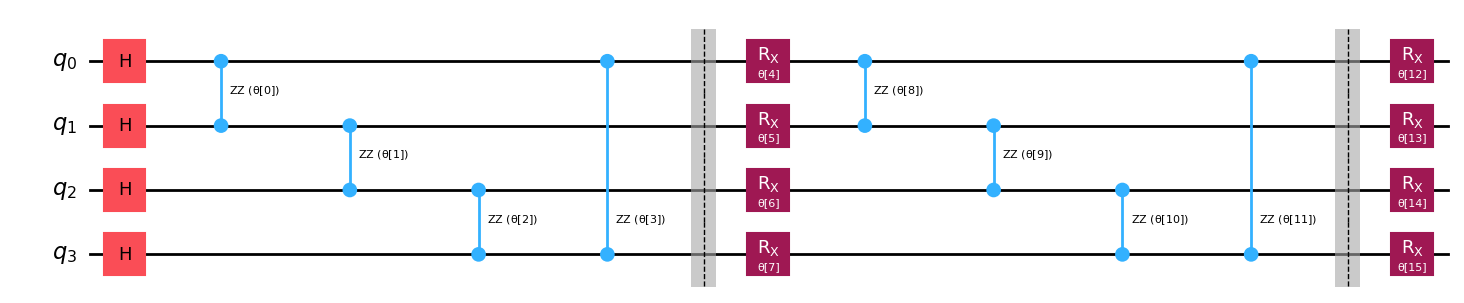

In [9]:
nqubits = 4
depth = 2
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 20)
circuit= ansatz_hamiltonian(nqubits, depth,parameter)
circuit.draw('mpl')

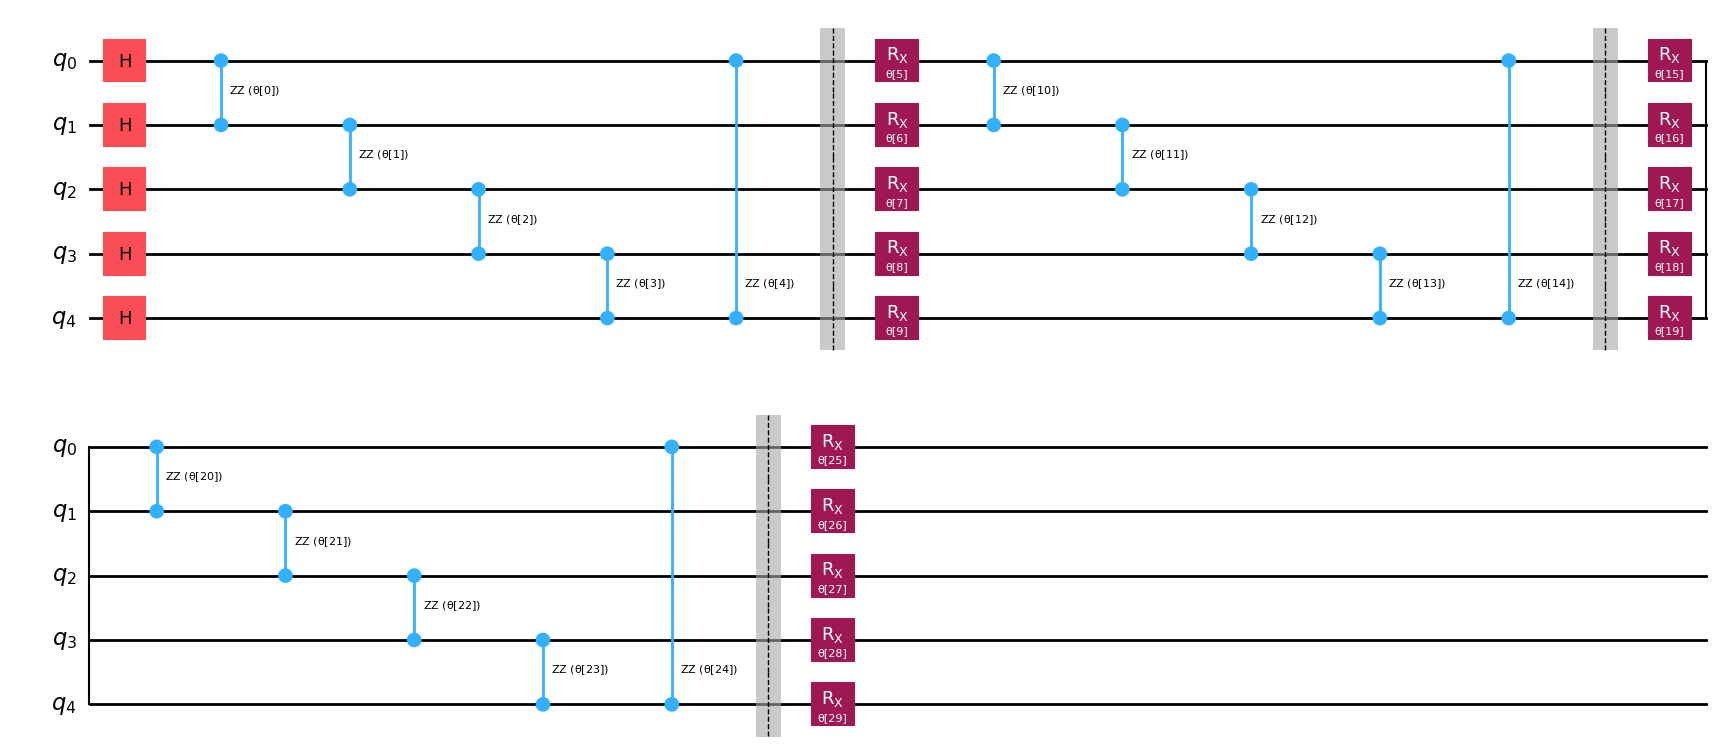

In [4]:
nqubits = 5
depth = 3
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 30)
circuit= ansatz_hamiltonian(nqubits, depth,parameter)
circuit.draw('mpl')

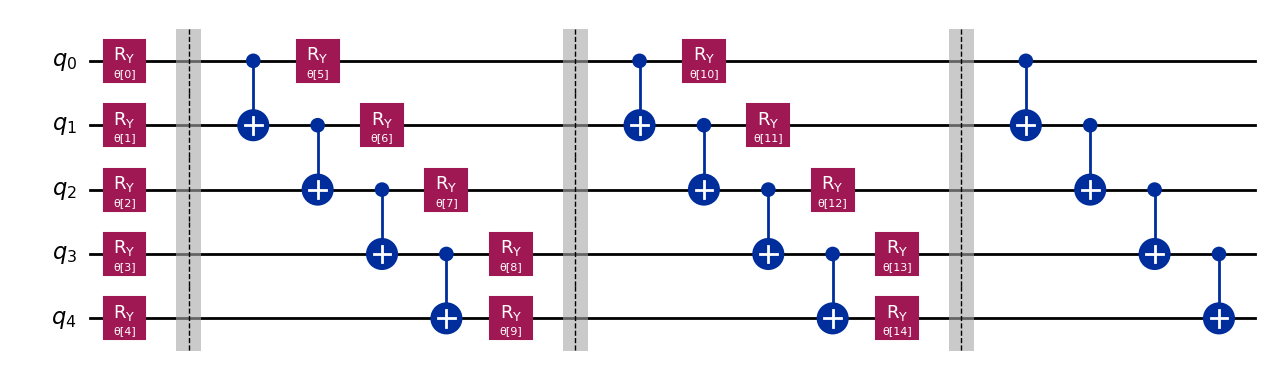

In [11]:
nqubits = 5
depth = 3
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 20)
circuit= ansatz_hea(nqubits, depth,parameter)
circuit.draw('mpl')

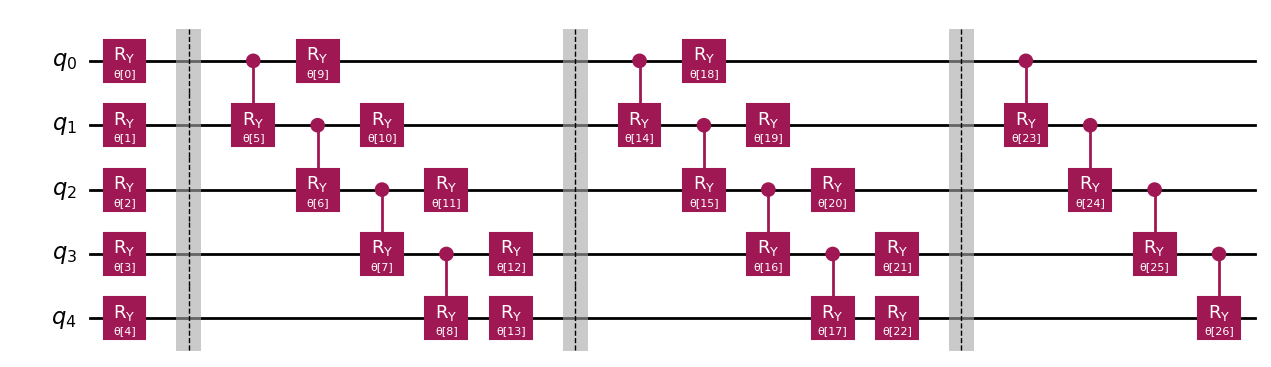

In [14]:
nqubits = 5
depth = 3
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 30)
circuit= ansatz_1(nqubits, depth,parameter)
circuit.draw('mpl')

In [16]:
ParameterVector('θ', depth*(nqubits*2-1))

ParameterVector(name='θ', length=27)

In [10]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
def callback(intermediate_result):
    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [11]:
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="CG", tol=1e-5, options={'disp': False}, callback=callback)

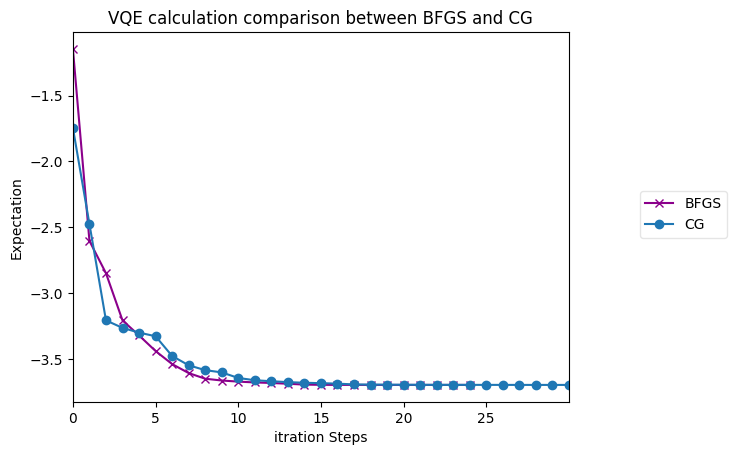

In [12]:
x = np.linspace(0, 200)
y = result_intermediate
y1 = result_intermediate1
fig, ax = plt.subplots()
ax.plot(y, label='BFGS', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='CG', marker='o', linestyle='-')
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
ax.set_title('VQE calculation comparison between BFGS and CG')
ax.set_xlabel('itration Steps')
ax.set_ylabel('Expectation')
ax.grid(False)
plt.show()

## pure vqe + probability correction

In [6]:
def get_hamiltonian(nqubits):
    J=1/np.sqrt(2)
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()

def ansatz_vqe(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits+1)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rx(params[t], i)
            t += 1
        circuit.ry(params[t], nqubits)
        t+=1
    return circuit




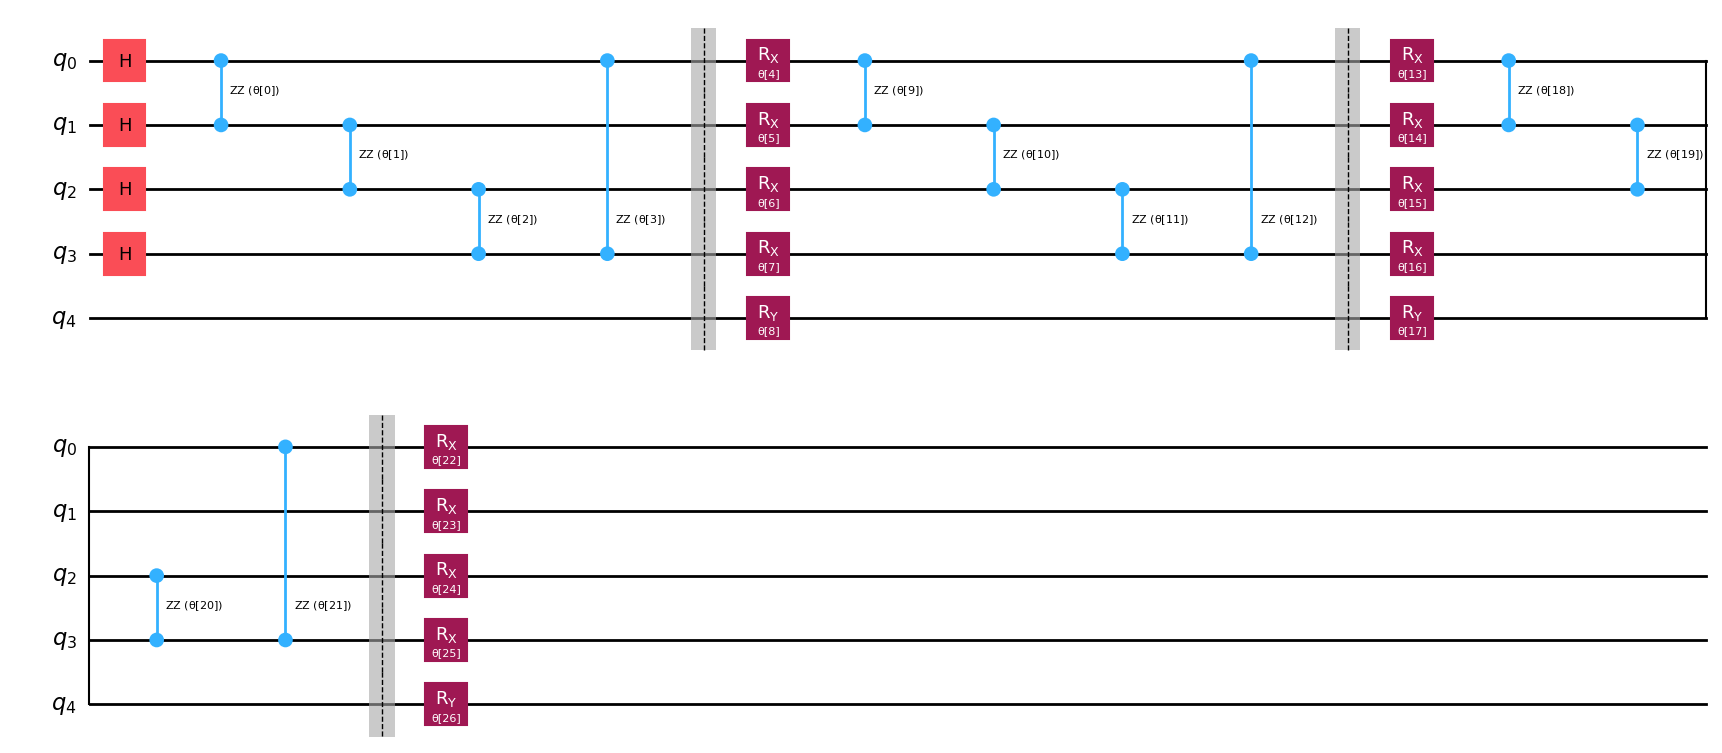

In [8]:
nqubits = 4
depth = 3
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 30)
circuit= ansatz_vqe(nqubits, depth,parameter)
circuit.draw('mpl')

In [15]:
def cost_function2(params, statevector):
    nqubits = 4
    depth = 2
    error_rate = 0
    hamiltonian =  get_hamiltonian(nqubits)
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits+1))
    circuit_temp = ansatz_vqe(nqubits, depth,params)
    qc = qc.compose(circuit_temp, range(nqubits+1))
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    qc.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(qc, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    circuit = transpile(qc, simulator)
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data[:2**nqubits]
    probability = u.conj().dot(u)
    return -probability

def unitary_vqe(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_before_list = []
    expectation_after_list = []
    probability_before_list = []
    probability_after_list = []
    initial_state = Statevector.from_label("0000")
    statevector = initial_state.data
    for i in range(step):
        ## cosine filter part
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        qc1 = qc.copy()
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data
        new_state0 = new_state[:2**nqubits]
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        if i ==0:
            probability = new_state0.conj().T.dot(new_state0)
        else:
            probability = new_state0.conj().T.dot(new_state0)
            probability *= probability_before_list[-1]
        #probability = new_state0.conj().T.dot(new_state0)
        probability_before_list.append(probability)
        expectation_before_list.append(expectation)
        # vqe part
        np.random.seed(42)
        parameter = np.array(np.random.random(depth*(nqubits*2+1)))
        estimate_val_hva = minimize(cost_function2, parameter, args=(new_state), method="BFGS", tol=1e-5, options={'disp': False})
        # after vqe
        new_param = np.real(estimate_val_hva.x)
        circuit_new = ansatz_vqe(nqubits, depth, new_param)
        qc1 = qc1.compose(circuit_new, range(nqubits+1))
        qc1.save_statevector()
        circuit = transpile(qc1, simulator)
        result1 = simulator.run(circuit).result().data(0)['statevector']
        new_state1 = result1.data
        new_state_0= new_state1[:2**nqubits]
        expectation = (new_state1.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state1)/(new_state1.conj().T.dot(hamiltonian2).dot(new_state1))
        if i ==0:
            probability = new_state_0.conj().T.dot(new_state_0)
        else:
            probability = new_state_0.conj().T.dot(new_state_0)
            probability *= probability_after_list[-1]
        #probability = new_state_0.conj().T.dot(new_state_0)
        expectation_after_list.append(expectation)
        probability_after_list.append(probability)
        statevector = new_state1[:2**nqubits]/np.linalg.norm(new_state1[:2**nqubits])
    return expectation_before_list, probability_before_list, expectation_after_list, probability_after_list

In [40]:
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("00000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 2
step = 40
#params = np.array(np.random.random(depth*(nqubits*2+1)))
#cost_function2(params, initial_state)
result = unitary_vqe(H, time, nqubits, order, time_step, error_rate, step)

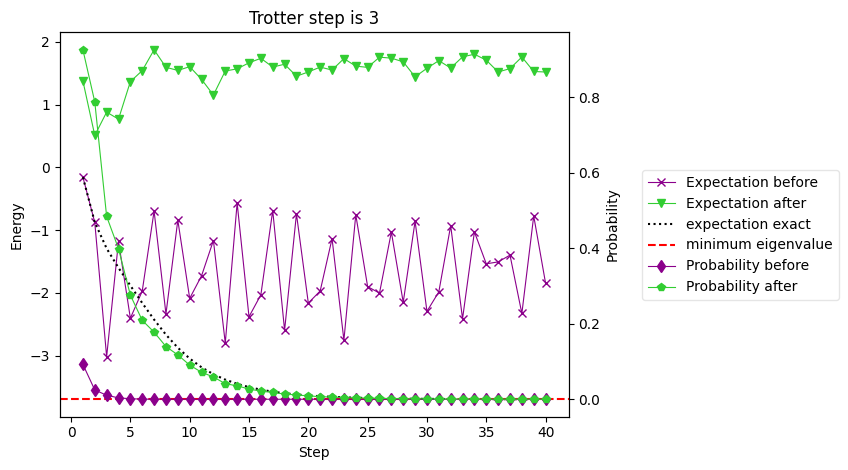

In [41]:
fig, axes = plt.subplots()
x = list(range(1, step+1))  # includes initial state
y1 = result[0]
y2 = result[1]
y3 = result[2]
y4 = result[3]
axes.plot(
    x, y1, label="Expectation before", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    x, y3, label="Expectation after", marker="v", c="limegreen", ls="-", lw=0.8
)
#axes.plot(
#    x, expectation_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
#)
axes.plot(x, expectation_exact, c="k", ls=":", label="expectation exact")
horizontal_line_value = emin
axes.axhline(y=horizontal_line_value, color='r', linestyle='--', label='minimum eigenvalue')


axes.set_xticks(np.arange(0, max(x) + 1, 5))
axes.set_xlabel('Step')
axes.set_ylabel('Energy')
axes.set_title('Trotter step is 3')

ax2 = axes.twinx()
ax2.plot(x, y2, label="Probability before", marker="d", c="darkmagenta", ls="-", lw=0.8)
ax2.plot(x, y4, label="Probability after", marker="p", c="limegreen", ls="-", lw=0.8)
#ax2.plot(x, probability_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8)
#ax2.plot(x, probability_exact, c="k", ls="-", lw=0.8, label="Exact matrix exponential")
ax2.set_ylabel('Probability')
handles1, labels1 = axes.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 合并句柄和标签
all_handles = handles1 + handles2
all_labels = labels1 + labels2
legend = fig.legend(
    all_handles,
    all_labels,
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()

In [21]:
def cost_function3(params, statevector):
    nqubits = 4
    depth = 2
    error_rate = 0
    hamiltonian =  get_hamiltonian(nqubits)
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits+1))
    circuit_temp = ansatz_vqe(nqubits, depth,params)
    qc = qc.compose(circuit_temp, range(nqubits+1))
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    qc.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(qc, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    circuit = transpile(qc, simulator)
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data[:2**nqubits]
    probability = u.conj().dot(u)
    return -probability

# Define the constraint function
def expectation_constraint(params, statevector, reference_expectation):
    nqubits = 4
    depth = 2
    max_increase = 1e-4
    # Create a new circuit based on the parameters.
    qc = QuantumCircuit(nqubits + 1)
    statevector_normalized = statevector / np.linalg.norm(statevector)
    qc.initialize(statevector_normalized, range(nqubits + 1))
    circuit_temp = ansatz_vqe(nqubits, depth, params)
    qc = qc.compose(circuit_temp, range(nqubits + 1))
    circuit = qc.decompose()
    simulator = AerSimulator()
    circuit.save_statevector()
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit).result()
    u = result.data(0)['statevector'].data
    
    # Compute the expectation value of the Hamiltonian.
    expectation_value = (u.conj().T.dot(hamiltonian1.to_matrix())).dot(u)/(u.conj().T.dot(hamiltonian2).dot(u))
    
    # The constraint is that the expectation should not increase by more than max_increase.
    return reference_expectation - expectation_value - max_increase

def unitary_vqe1(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_before_list = []
    expectation_after_list = []
    probability_before_list = []
    probability_after_list = []
    initial_state = Statevector.from_label("0000")
    statevector = initial_state.data
    for i in range(step):
        ## cosine filter part
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        qc1 = qc.copy()
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data
        new_state0 = new_state[:2**nqubits]
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        reference_expectation = expectation
        if i ==0:
            probability = new_state0.conj().T.dot(new_state0)
        else:
            probability = new_state0.conj().T.dot(new_state0)
            probability *= probability_before_list[-1]
        #probability = new_state0.conj().T.dot(new_state0)
        probability_before_list.append(probability)
        expectation_before_list.append(expectation)
        # vqe part
        np.random.seed(42)
        parameter = np.array(np.random.random(depth*(nqubits*2+1)))
        # 定义约束
        cons = ({'type': 'ineq', 'fun': lambda params: expectation_constraint(params, new_state, reference_expectation)})
        estimate_val_hva = minimize(cost_function3, parameter, args=(new_state), method="SLSQP", constraints=cons)
        # after vqe
        new_param = np.real(estimate_val_hva.x)
        circuit_new = ansatz_vqe(nqubits, depth, new_param)
        qc1 = qc1.compose(circuit_new, range(nqubits+1))
        qc1.save_statevector()
        circuit = transpile(qc1, simulator)
        result1 = simulator.run(circuit).result().data(0)['statevector']
        new_state1 = result1.data
        new_state_0= new_state1[:2**nqubits]
        expectation = (new_state1.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state1)/(new_state1.conj().T.dot(hamiltonian2).dot(new_state1))
        if i ==0:
            probability = new_state_0.conj().T.dot(new_state_0)
        else:
            probability = new_state_0.conj().T.dot(new_state_0)
            probability *= probability_after_list[-1]
        #probability = new_state_0.conj().T.dot(new_state_0)
        expectation_after_list.append(expectation)
        probability_after_list.append(probability)
        statevector = new_state1[:2**nqubits]/np.linalg.norm(new_state1[:2**nqubits])
    return expectation_before_list, probability_before_list, expectation_after_list, probability_after_list
    
# Example usage
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("00000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 2
step = 40
#params = np.array(np.random.random(depth*(nqubits*2+1)))
#cost_function2(params, initial_state)
result1 = unitary_vqe1(H, time, nqubits, order, time_step, error_rate, step)

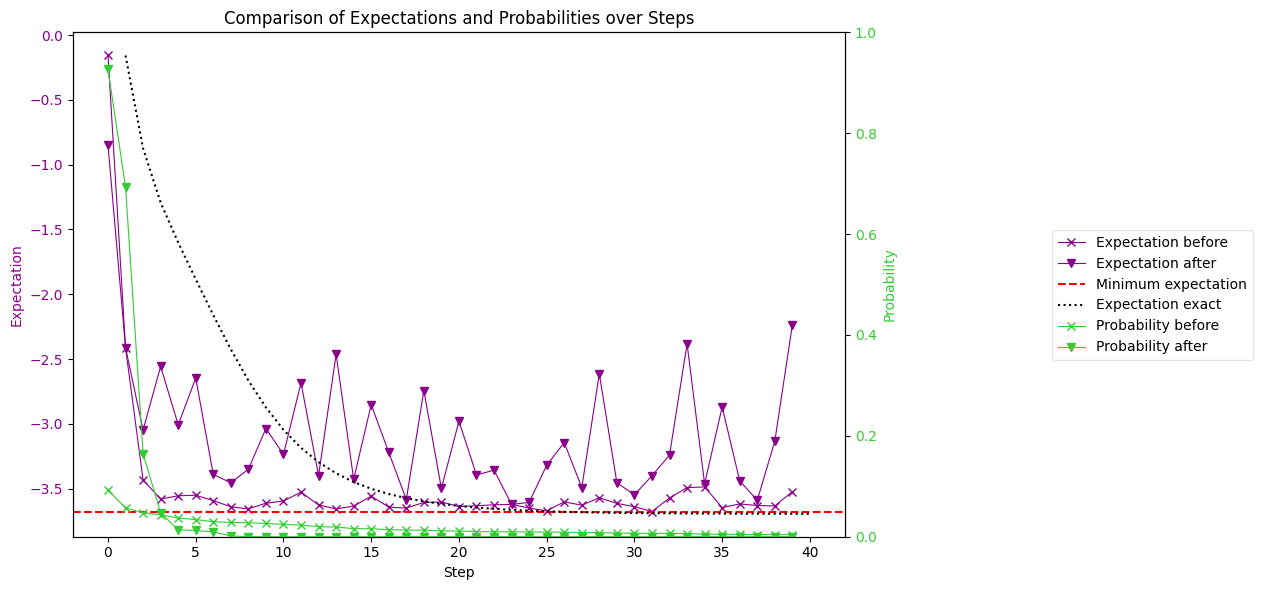

In [29]:
y1 = result1[0]
y2 = result1[1]
y3 = result1[2]
y4 = result1[3]

step = list(range(40))  # 横坐标从0到40

# 创建图形和主轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 设置颜色和标记样式
colors = ['darkmagenta', 'limegreen', 'k']
markers = ['x', 'v', ':']

# 绘制 y1 和 y3 在主轴上
ax1.plot(step, y1, label="Expectation before", marker=markers[0], c=colors[0], ls="-", lw=0.8)
ax1.plot(step, y3, label="Expectation after", marker=markers[1], c=colors[0], ls="-", lw=0.8)
ax1.axhline(y=np.min([y1, y3]), color='r', linestyle='--', label='Minimum expectation')
ax1.plot(x, expectation_exact, c="k", ls=":", label="Expectation exact")
# 设置主轴标签
ax1.set_xlabel('Step')
ax1.set_ylabel('Expectation', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# 创建共享 x 轴但 y 轴不同的第二个轴 ax2
ax2 = ax1.twinx()

# 绘制 y2 和 y4 在第二轴上
ax2.plot(step, y2, label="Probability before", marker=markers[0], c=colors[1], ls="-", lw=0.8)
ax2.plot(step, y4, label="Probability after", marker=markers[1], c=colors[1], ls="-", lw=0.8)

# 设置第二轴标签
ax2.set_ylabel('Probability', color=colors[1])  # 我们假设概率范围是0到1
ax2.set_ylim(0, 1)  # 设置概率轴的范围
ax2.tick_params(axis='y', labelcolor=colors[1])

# 获取所有 Axes 对象中的句柄和标签并合并它们
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 合并句柄和标签
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# 创建一个共同的图例
legend = fig.legend(
    all_handles,
    all_labels,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    framealpha=0.5,
)

# 设置标题和其他细节
ax1.set_title('Comparison of Expectations and Probabilities over Steps')

# 调整布局以防止图例与子图重叠
fig.tight_layout()

# 因为 fig.legend 默认会考虑图例的空间，所以可能需要手动调整右边距
fig.subplots_adjust(right=0.85)

plt.show()

## Test

In [32]:
def cost_function3(params, statevector):
    nqubits = 4
    depth = 2
    error_rate = 0
    hamiltonian =  get_hamiltonian(nqubits)
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits+1))
    circuit_temp = ansatz_vqe(nqubits, depth,params)
    qc = qc.compose(circuit_temp, range(nqubits+1))
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    qc.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(qc, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    circuit = transpile(qc, simulator)
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data[:2**nqubits]
    probability = u.conj().dot(u)
    return -probability

# Define the constraint function
def expectation_constraint(params, statevector, reference_expectation):
    nqubits = 4
    depth = 2
    max_increase = 1e-4
    # Create a new circuit based on the parameters.
    qc = QuantumCircuit(nqubits + 1)
    statevector_normalized = statevector / np.linalg.norm(statevector)
    qc.initialize(statevector_normalized, range(nqubits + 1))
    circuit_temp = ansatz_vqe(nqubits, depth, params)
    qc = qc.compose(circuit_temp, range(nqubits + 1))
    circuit = qc.decompose()
    simulator = AerSimulator()
    circuit.save_statevector()
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit).result()
    u = result.data(0)['statevector'].data
    
    # Compute the expectation value of the Hamiltonian.
    expectation_value = (u.conj().T.dot(hamiltonian1.to_matrix())).dot(u)/(u.conj().T.dot(hamiltonian2).dot(u))
    
    # The constraint is that the expectation should not increase by more than max_increase.
    return reference_expectation - expectation_value - max_increase

def unitary_vqe2(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_before_list = []
    expectation_after_list = []
    probability_before_list = []
    probability_after_list = []
    initial_state = Statevector.from_label("0000")
    statevector = initial_state.data
    for i in range(step):
        ## cosine filter part
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        qc1 = qc.copy()
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data
        new_state0 = new_state[:2**nqubits]
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        reference_expectation = expectation
        if i ==0:
            probability = new_state0.conj().T.dot(new_state0)
        else:
            probability = new_state0.conj().T.dot(new_state0)
            probability *= probability_before_list[-1]
        #probability = new_state0.conj().T.dot(new_state0)
        probability_before_list.append(probability)
        expectation_before_list.append(expectation)
        # vqe part
        np.random.seed(42)
        parameter = np.array(np.random.random(depth*(nqubits*2+1)))
        # 定义约束
        cons = ({'type': 'ineq', 'fun': lambda params: expectation_constraint(params, new_state, reference_expectation)})
        estimate_val_hva = minimize(cost_function3, parameter, args=(new_state), method="SLSQP", constraints=cons)
        # after vqe
        new_param = estimate_val_hva.x
        circuit_new = ansatz_vqe(nqubits, depth, new_param)
        qc1 = qc1.compose(circuit_new, range(nqubits+1))
        qc1.save_statevector()
        circuit = transpile(qc1, simulator)
        result1 = simulator.run(circuit).result().data(0)['statevector']
        new_state1 = result1.data
        new_state_0= new_state1[:2**nqubits]
        expectation = (new_state1.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state1)/(new_state1.conj().T.dot(hamiltonian2).dot(new_state1))
        if i ==0:
            probability = new_state_0.conj().T.dot(new_state_0)
        else:
            probability = new_state_0.conj().T.dot(new_state_0)
            probability *= probability_after_list[-1]
        #probability = new_state_0.conj().T.dot(new_state_0)
        expectation_after_list.append(expectation)
        probability_after_list.append(probability)
        statevector = new_state1[:2**nqubits]/np.linalg.norm(new_state1[:2**nqubits])
    return expectation_before_list, probability_before_list, expectation_after_list, probability_after_list
    
# Example usage
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 3 #time_step
initial_state = Statevector.from_label("00000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 2
step = 5
#params = np.array(np.random.random(depth*(nqubits*2+1)))
#cost_function2(params, initial_state)
result2 = unitary_vqe1(H, time, nqubits, order, time_step, error_rate, step)

In [33]:
result2

([np.complex128(-0.15549458140967454+1.8785865158618704e-17j),
  np.complex128(-2.4126950337047495-1.7978088449659827e-16j),
  np.complex128(-3.434606127251487+0j),
  np.complex128(-3.58106562634704-2.417079450049774e-16j),
  np.complex128(-3.5557938916199374+0j)],
 [np.complex128(0.09234195291670871+0j),
  np.complex128(0.057025062789098684+0j),
  np.complex128(0.047452352335801744+0j),
  np.complex128(0.04359202518952992+0j),
  np.complex128(0.037013764016493284+0j)],
 [np.complex128(-0.8477219957998288-5.991876560931095e-17j),
  np.complex128(-2.413331897415937-1.4830401777178076e-16j),
  np.complex128(-3.0475293885835026+0j),
  np.complex128(-2.5572135129654328-1.9364671265270378e-16j),
  np.complex128(-3.0077565036236362+1.9272937237891487e-16j)],
 [np.complex128(0.9264401672292093+0j),
  np.complex128(0.693545070490438+0j),
  np.complex128(0.16482361253859226+0j),
  np.complex128(0.047248664109890266+0j),
  np.complex128(0.013608863592013477+0j)])